# EDA with only datetime

We are interested with the dependent variables which is `fare_amount` in this dataset. I want to isolate its relationship with `pickup_datetime` (and `passenger_count` which I might work on in future). Note that this might not always work for other kinds of dataset with other kinds of features. In this case, `date_time` vs pickup/dropoff coordinates is basically time dimension vs space dimension, so I assume we can safely say they are orthogonal features.

TLDR:
1. I choose to do this EDA without the pickup and dropoff coordinates to reduce memory usage in order to read the entire csv files of 55 million rows.
1. By selectively choosing the columns during CSV file reading, we can reduce the memory usage and loading time.
1. By saving the raw dataframe to feather format, we can reload the entire dataframe in subsequent session even faster without re-reading the CSV file again.
1. Test data distribution is quite **different** from training data in terms of monthly total taxi rides. Not my discovery. Derived from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering)
1. We observed a jump in cab fare in **Sept 2012** which is confirmed by the news of [New York Taxis to Start Charging Increased Rates](https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html)
1. We deduced **\$2.50** as the reasonable minimum cut-off point to remove outliers. 
1. We deduced a maximum fare of **\$500** as the reasonable maximum cut-off point to remove outliers. 
1. We observed the outliers of maximum and minimum fare fall in almost all the same period of time.

# Import libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
PATH = 'data/nyc-taxi/'

# Load data csv format
(This section only needs to be executed once. Subsequently,once feather format data is created, jump straight to [loading from feather format](#load_feather) which is much faster!

In [4]:
types = {'fare_amount': 'float32',
         'passenger_count': 'uint8'}

# Columns to load for training data
cols_train = ['fare_amount', 'pickup_datetime', 'passenger_count']

# Columns to load for test data
cols_test = ['pickup_datetime', 'passenger_count']

In [5]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. 

In [6]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], usecols=cols_train,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    print(f'DataFrame Chunk {i}')
    df_list.append(df_chunk) 

DataFrame Chunk 1
DataFrame Chunk 2
DataFrame Chunk 3
DataFrame Chunk 4
DataFrame Chunk 5
DataFrame Chunk 6
Wall time: 4min 22s


In [7]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

In [8]:
del df_list

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 3 columns):
fare_amount        float32
pickup_datetime    datetime64[ns]
passenger_count    uint8
dtypes: datetime64[ns](1), float32(1), uint8(1)
memory usage: 687.1 MB


This has only used less than **700Mb** of memory for the entire **55 million rows** of data.

(Bear in mind that we have purposely disregard pickup and dropoff coordinates for this analysis, otherwise it would consume about **1.5Gb** of memory instead)

As comparison, an eat-all-you-can loading such as:

`train_df =  pd.read_csv('data/nyc-taxi/train.csv', nrows = 10_000_000)`

will result in about **610Mb** just for the first **10 million rows**.

(or more than **3Gb** of memory for entire **55 million rows**!)

In [10]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-no-gps')

Wall time: 9.78 s


In [11]:
test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)

In [12]:
test_df.to_feather('tmp/taxi-test-no-gps')

# Load data feather format
(begin from here directly once we have the feather format file)

In [4]:
%%time
train_df = pd.read_feather('tmp/taxi-train-no-gps')

Wall time: 19 s


Notice it took few seconds to load the full 55 million rows of data which we took **4 minutes+** to load earlier :)

In [5]:
test_df = pd.read_feather('tmp/taxi-test-no-gps')

In [7]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,passenger_count
0,4.5,2009-06-15 17:26:21,1
1,16.9,2010-01-05 16:52:16,1
2,5.7,2011-08-18 00:35:00,2
3,7.7,2012-04-21 04:30:42,1
4,5.3,2010-03-09 07:51:00,1


,fare_amount,pickup_datetime,passenger_count
55423851,14.0,2014-03-15 03:28:00,1
55423852,4.2,2009-03-24 20:46:20,1
55423853,14.1,2011-04-02 22:04:24,1
55423854,28.9,2011-10-26 05:57:51,1
55423855,7.5,2014-12-12 11:33:00,1


In [8]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,passenger_count
0,2015-01-27 13:08:24,1
1,2015-01-27 13:08:24,1
2,2011-10-08 11:53:44,1
3,2012-12-01 21:12:12,1
4,2012-12-01 21:12:12,1


,pickup_datetime,passenger_count
9909,2015-05-10 12:37:51,6
9910,2015-01-12 17:05:51,6
9911,2015-04-19 20:44:15,6
9912,2015-01-31 01:05:19,6
9913,2015-01-18 14:06:23,6


# Group and aggregate by year-month

In [12]:
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year,Month)")
    plt.title(title)
    plt.show()

In [6]:
# Group all training data rides by month+year combination and aggregate them by count, mean, median, min and max
fare_grouped_df = train_df.fare_amount.groupby([train_df.pickup_datetime.dt.year,train_df.pickup_datetime.dt.month])

fare_count_df = fare_grouped_df.count()
fare_mean_df = fare_grouped_df.mean()
fare_median_df = fare_grouped_df.median()
fare_min_df = fare_grouped_df.min()
fare_max_df = fare_grouped_df.max()

## Monthly ride count

This entire section is basically derived from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering) by @akosciansky

In [7]:
 fare_count_df.describe()

count        78.000000
mean     710562.256410
std       48398.599676
min      557375.000000
25%      683213.250000
50%      714990.500000
75%      743938.000000
max      804979.000000
Name: fare_amount, dtype: float64

During the 78 months period, there was an average of 710k rides per month. 

The median value 715k rides.

Standard deviation of 48k million rides.

The minimum recorded monthly ride is about 557k while the maximum is 805k.

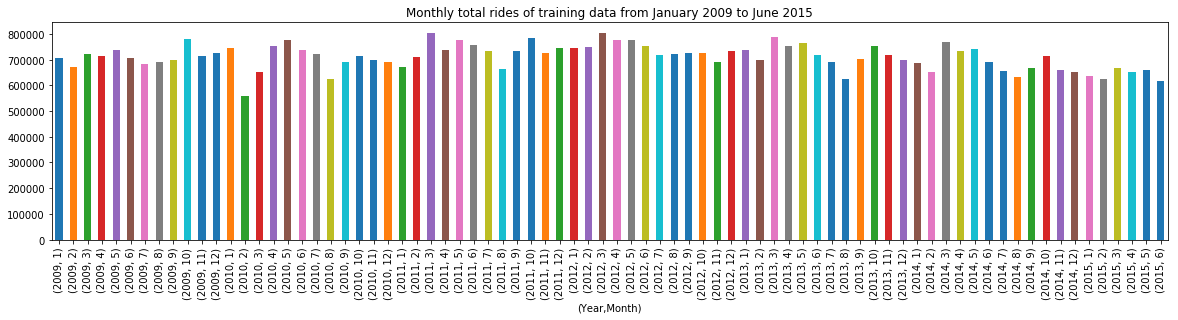

In [14]:
draw_barchart(fare_count_df, 'Monthly total rides of training data from January 2009 to June 2015')

No obvious patterns can be seen from the bar chart. We will revisit this in future.

We can also do the same for test data, since we are only concern with the count of rides here, not the fare

In [16]:
test_group_df = test_df.pickup_datetime.groupby([test_df.pickup_datetime.dt.year,test_df.pickup_datetime.dt.month]).count()

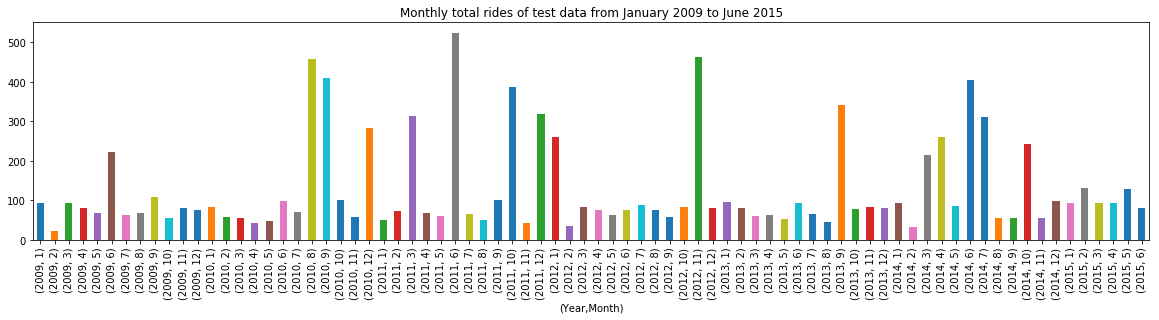

In [17]:
draw_barchart(test_group_df, 'Monthly total rides of test data from January 2009 to June 2015')

While training data has a relative uniform monthly total rides, 
the test data monthly total rides are not spread evenly, with some random huge spikes 

## Monthly mean fare

In [14]:
fare_mean_df.describe()

count    78.000000
mean     11.367785
std       1.312047
min       9.568311
25%      10.212288
50%      10.659033
75%      12.736461
max      13.684370
Name: fare_amount, dtype: float64

During the 78 months period, the average fare paid is \$11.37.

The median fare \$10.66.

Standard deviation of fare is \$1.31.

The minimum monthly mean fare is \$9.57 while maximum monthly mean fare is \$13.68.

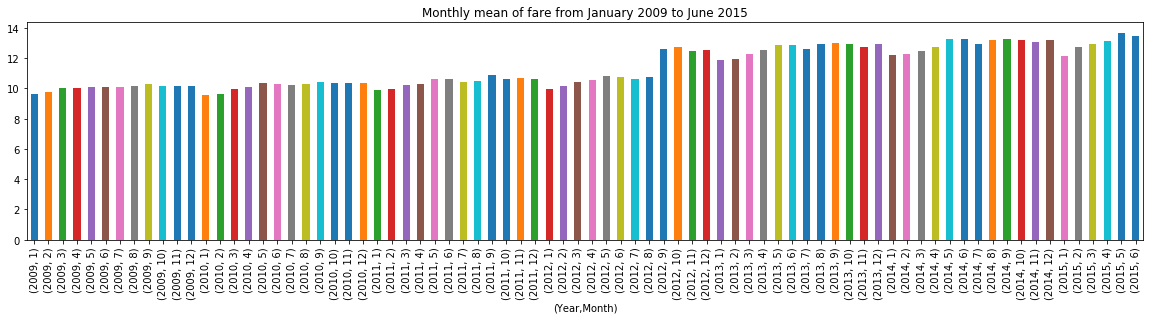

In [18]:
draw_barchart(fare_mean_df,'Monthly mean of fare from January 2009 to June 2015')

From January 2009 until September 2012, the monthly mean fare is quite uniform. 

There is a gradual increase from January until December before it dropped again on January of following year.

However, there is a big jump from October 2012 onwards. The monthly mean fare increased by about \$3 during this period. Probably a price increase at this point onwards.

The pattern where the monthly mean fare drops from December to January remains true during this period.

## Monthly median fare

In [16]:
fare_median_df.describe()

count    78.000000
mean      8.487180
std       0.847205
min       7.300000
25%       7.700000
50%       8.100000
75%       9.500000
max      10.000000
Name: fare_amount, dtype: float64

During the 78 months period, there average fare paid is \$8.49.

The median \$8.10.

Standard deviation of fare is \$0.85.

The minimum monthly median fare is \$7.30 while maximum monthly median fare is \$10.00.

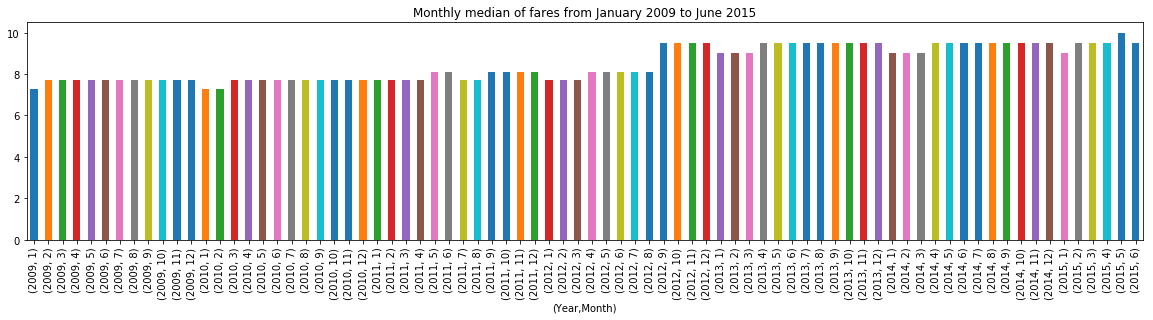

In [19]:
draw_barchart(fare_median_df,'Monthly median of fares from January 2009 to June 2015')

Here we can see the median is relatively uniform from January 2009 to September 2012

Not surprisingly, as we've seen in the monthly mean fare bar chart, there is a big jump from October 2012 onwards. 

The monthly median fare increased permanently by about almost \$2.00 during this period of September 2012 to June 2015.

A quick Google search shows this is true

https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html

## Monthly minimum fare

In [18]:
fare_min_df.describe()

count     78.000000
mean     -15.734744
std       58.026012
min     -300.000000
25%        2.500000
50%        2.500000
75%        2.500000
max        2.500000
Name: fare_amount, dtype: float64

The 25% percentile, 50% percentile (median) and 75% percentile all shows \$2.5. Which is probably the real minimum fare.

Most people just assume assume minimum fare of \$0 and drop the negative fares. We need to dig deeper.

In [34]:
print(f"Number of rides below $0: \t\t{len(train_df.fare_amount[train_df.fare_amount<0])}")
print(f"Number of rides at $0: \t\t\t{len(train_df.fare_amount[train_df.fare_amount==0])}")
print(f"Number of rides between $0.01 & $2.49:  {len(train_df.fare_amount[train_df.fare_amount.between(0,2.50,inclusive=False)])}")
print()
print(f"Number of rides below $2.50(all above): {len(train_df.fare_amount[train_df.fare_amount<2.5])}")
print()
print(f"Number of rides at $2.50: \t\t{len(train_df.fare_amount[train_df.fare_amount==2.5])}")
print(f"Number of rides of more than $2.50: \t{len(train_df.fare_amount[train_df.fare_amount>2.5])}")

Number of rides below $0: 		2454
Number of rides at $0: 			1380
Number of rides between $0.01 & $2.49:  913

Number of rides below $2.50(all above): 4747

Number of rides at $2.50: 		224309
Number of rides of more than $2.50: 	55194800


There are 2,454 cases of negative fare, 1,380 cases of zero fares and 913 cases more than $0 but below \$2.50. This three categories add up to 4,747 cases.

There are 224,309 cases at \$2.50 in comparison.

From above we can see above that \$2.50 would be a more reasonable minimum fare, as can be confirmed below:

http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

Hence we should remove those below **\$2.50** as outliers, instead of just dropping rows with negative fares.

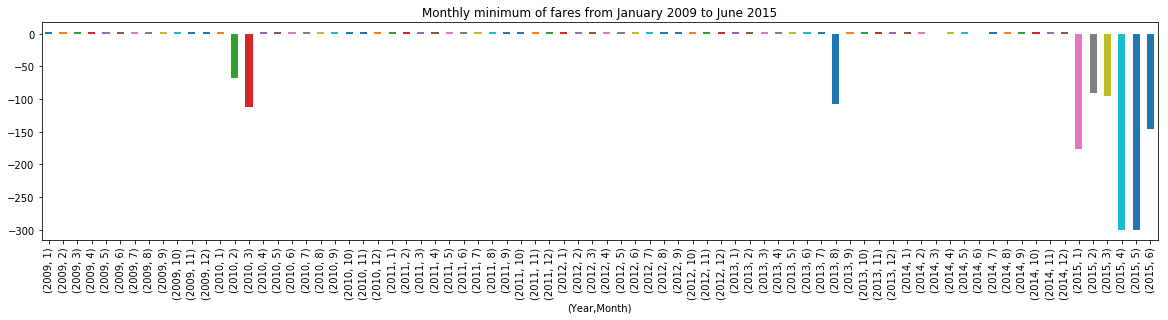

In [20]:
draw_barchart(fare_min_df, 'Monthly minimum of fares from January 2009 to June 2015')

Many minimum fare outliers fall in few periods, such as February 2010, March 2010, August 2013, and January to June of 2015. 

Removing all rows with fare below \$.250 will remove those outliers.

## Monthly maximum fare

In [21]:
fare_max_df.describe()

count       78.000000
mean      3525.962402
std      15073.134766
min        199.300003
25%        371.250000
50%        450.000000
75%        499.742493
max      93963.359375
Name: fare_amount, dtype: float64

There are obviously some extreme values we need to get rid of before the statistics would make any sense.

The mean value of \$3526 for taxi ride is absurd.

Unlike minimum fare, we have no way of working out the optimal value for maximum fare.

Obviously, this is where the dependency with pickup and dropoff coordinates matters more - from where, to where, and how far you travel determines how much is the fare, instead of date and time when you travel.

We rely more on visualization help from barchart this time.

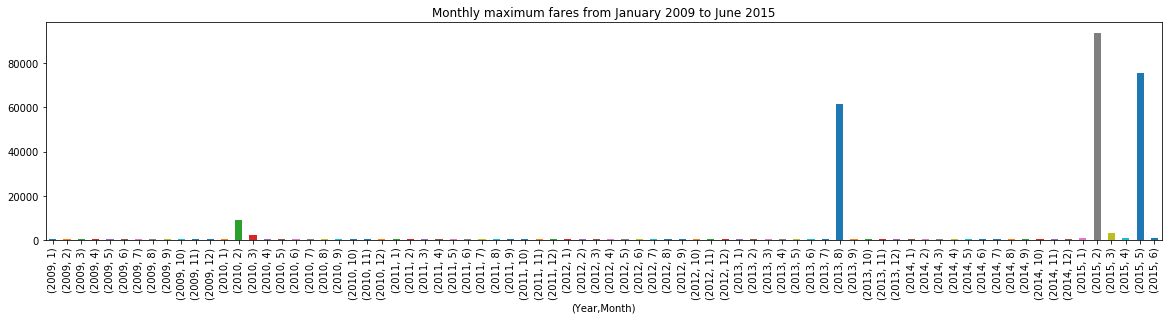

In [21]:
draw_barchart(fare_max_df, 'Monthly maximum fares from January 2009 to June 2015')

The chart above points us to the first few outliers maximum fare that we should remove immediately.

Quite similar to the monthly minimum fare chart, there are outliers in the same periods, namely February 2010, 
March 2010, August 2013, and January to June of 2015 (more apparent in February and May).

We can sort the maximum monthly fare for easier observation.

In [24]:
sorted_max_fare = fare_max_df.sort_values(ascending=False)

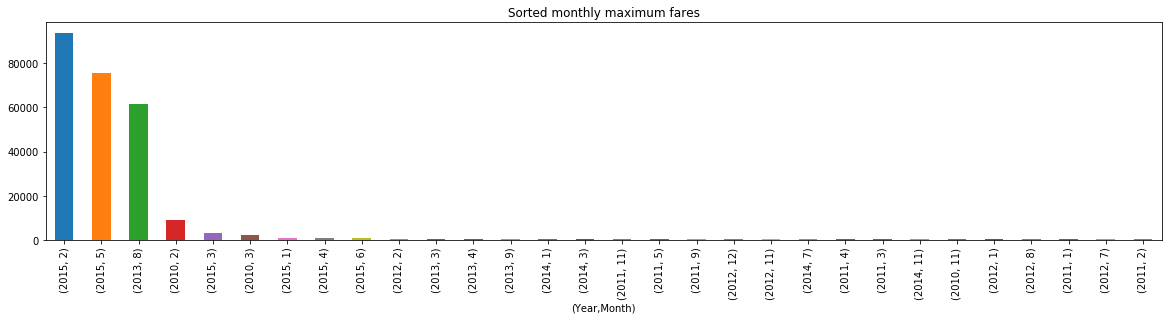

In [25]:
draw_barchart(sorted_max_fare.head(30), 'Sorted monthly maximum fares')

In [25]:
sorted_max_fare.head(30)

pickup_datetime  pickup_datetime
2015             2                  93963.359375
                 5                  75747.023438
2013             8                  61550.859375
2010             2                   9000.410156
2015             3                   3130.300049
2010             3                   2023.699951
2015             1                    978.000000
                 4                    957.000000
                 6                    900.000000
2012             2                    500.000000
2013             3                    500.000000
                 4                    500.000000
                 9                    500.000000
2014             1                    500.000000
                 3                    500.000000
2011             11                   500.000000
                 5                    500.000000
                 9                    500.000000
2012             12                   500.000000
                 11                 

From the sorted values above, we can safely remove those above **\$500.00** as outliers at this point.

This is better than just picking a cab fare maximum value by gut feeling.

Never mind that the maximum values of \$500.00 for taxi fare is still quite exaggerating. We will need to revisit this with  pickup and dropoff coordinates in future.

# Summary Findings

1. By selectively choosing the columns/features during CSV file loading, we can reduce the memory usage of reading the **entire csv files of 55 million rows from 3Gb to 700Mb**.
1. By saving the raw dataframe to feather format, we can reload the entire dataframe in subsequent session much faster without re-reading the CSV file again, from **minutes to seconds**.
1. Test data distribution is quite **different** from training data in terms of monthly total taxi rides. This is not my discovery, I derived from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering).
    - Implication: This could affect how we create our validation data in order to maximize our test data score.
1. From monthly mean and media fare, we observed a jump in cab fare is September 2012 which is confirmed by the news of [New York Taxis to Start Charging Increased Rates](https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html)
    - Implication:  For certain models (especially linear models?), maybe it's better to create two models and separate the data for 2 separate timings, before and after September 2012.
1. From monthly minimum fare, we obvserved high occurence of **\$2.50**, which is the real minimum fare for NYC taxi ride. 
    - Implication: It's better than just simply removing rows with negative fare.
1. From monthly maximum fare, we deduced a maximum fare of **\$500** as the reasonable cut-off point to remove outliers. 
    - Implication: It's better than guesstimate a maximum taxi fare for cutoff
1. We also observe the outliers of maximum and minimum fare almost fall in the same period of time.
    - Implication: We want to pay attention to these periods and see if there are other anomalies?

# TODO

1. Remove outliers based on the findings above. See how much outliers we removed.
1. Revisit all the monthly group and aggregates after the previous step, see if we have cleaner data.
1. Consider passenger_count in the next EDA
1. Consider adding a holiday or calendar events column to see if holiday or other events affect the taxi ride count.
1. Use the cleaned data and proceed to do EDA based on pickup and dropoff coordinates next.